In [86]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout 
import matplotlib.pyplot as plt 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [65]:
df = pd.read_csv('../data/Data_A.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']

price_df = df[price_cols]

min_price = price_df.min().min()
max_price = price_df.max().max()

vol_df = df[vol_cols]

min_vol = vol_df.min().min()
max_vol = vol_df.max().max()

price_transformer = lambda x: (x-min_price)/(max_price-min_price)
vol_transformer = lambda x: (x-min_vol)/(max_vol-min_vol)

df[vol_cols] = vol_transformer(df[vol_cols])
df[price_cols] = price_transformer(df[price_cols])

df['bs_pressure1'] = (df['bs_lob_1_v']>df['ss_lob_1_v']).astype(int)
df['bs_pressure2'] = ((df['bs_lob_1_v']+df['bs_lob_2_v'])>(df['ss_lob_1_v']+df['ss_lob_2_v'])).astype(int)

df['l1_diff']= df['ss_lob_1_v']-df['bs_lob_1_v']
df['avg_5'] = df[prev_mid_m_cols].mean(axis=1)
df['momentum_up'] = (df['avg_5']>0.5).astype(int)



In [67]:
df

,midprice_up,ss_lob_1_p,ss_lob_1_v,bs_lob_1_p,bs_lob_1_v,ss_lob_2_p,ss_lob_2_v,bs_lob_2_p,bs_lob_2_v,ss_lob_3_p,...,c1,c2,c3,c4,c5,bs_pressure1,bs_pressure2,l1_diff,avg_5,momentum_up
0,1,0.303750,0.000000,0.302500,0.001359,0.304375,0.000676,0.301250,0.002042,0.305000,...,0,1,0,1,0,1,1,-0.001359,0.4,0
1,1,0.292500,0.000676,0.291875,0.000676,0.293125,0.006413,0.291250,0.000676,0.293750,...,0,1,0,1,0,0,0,0.000000,0.4,0
2,1,0.818750,0.000676,0.818125,0.000874,0.819375,0.003408,0.817500,0.001359,0.820000,...,0,1,1,0,0,1,0,-0.000198,0.4,0
3,0,0.220625,0.001359,0.219375,0.000676,0.221250,0.000676,0.218750,0.000676,0.221875,...,0,1,1,0,1,0,0,0.000683,0.6,1
4,0,0.789375,0.002042,0.788750,0.000676,0.790000,0.000676,0.787500,0.001359,0.790625,...,0,0,1,1,0,0,0,0.001366,0.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0.304375,0.002725,0.303125,0.003408,0.305000,0.002042,0.302500,0.004774,0.305625,...,1,0,1,1,1,1,1,-0.000683,0.8,1
99996,1,0.208125,0.000676,0.207500,0.003408,0.208750,0.004166,0.206875,0.003114,0.209375,...,0,1,0,1,0,1,1,-0.002732,0.4,0
99997,0,0.010000,0.002732,0.009375,0.000676,0.010625,0.004808,0.008750,0.005457,0.011250,...,1,0,1,0,0,0,0,0.002056,0.4,0
99998,1,0.391875,0.000676,0.391250,0.000191,0.392500,0.002042,0.390625,0.000676,0.393125,...,0,1,0,1,0,0,0,0.000485,0.4,0


In [66]:
df['midprice_up'].value_counts()

1    50267
0    49733
Name: midprice_up, dtype: int64

In [4]:
df['avg_5'] = df[['c1','c2','c3','c4','c5']].mean(axis=1)
df[df['midprice_up']==1]['avg_5'].mean()

0.48705910438259703

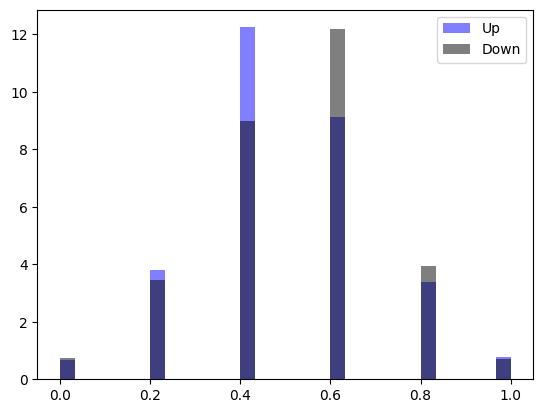

In [5]:
fig, ax = plt.subplots()
ax.hist(df[df['midprice_up']==1]['avg_5'], label='Up', color='b', alpha=0.5, density=True, bins=30)
ax.hist(df[df['midprice_up']==0]['avg_5'], label='Down', color='k', alpha=0.5, density=True, bins=30)
ax.legend()
plt.show()

## clearly a mean reversion relationship 

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


#### Fit a random forest

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

rf = RandomForestClassifier(n_estimators = 100, max_depth=9)

fit = rf.fit(X_train,y_train.to_numpy())
y_pred = fit.predict(X_test)

print('test accuracy')
print(accuracy_score(y_test, y_pred))

print('\ntrain accuracy')
print(accuracy_score(y_train, fit.predict(X_train)))

C:\Users\George\AppData\Local\Temp\ipykernel_16492\1366574444.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit = rf.fit(X_train,y_train.to_numpy())


test accuracy
0.7748

train accuracy
0.7901733333333333


#### Use RF to find important features

In [104]:

Y = df[['midprice_up']]
X = df.drop(columns=['midprice_up','ss_lob_1_p', 'bs_lob_1_p', 'ss_lob_2_p', 'bs_lob_2_p', 'ss_lob_3_p','bs_lob_3_p', 'ss_lob_4_p', 'bs_lob_4_p', 'bs_pressure2']
)
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, max_depth=7, max_features=5))
sel.fit(X, Y)

selected_feat= X.columns[(sel.get_support())]
s = pd.Series(index=sel.estimator_.feature_names_in_, data=sel.estimator_.feature_importances_)

c:\Users\George\projects\masters\dl_cw\venv\lib\site-packages\sklearn\feature_selection\_from_model.py:355: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


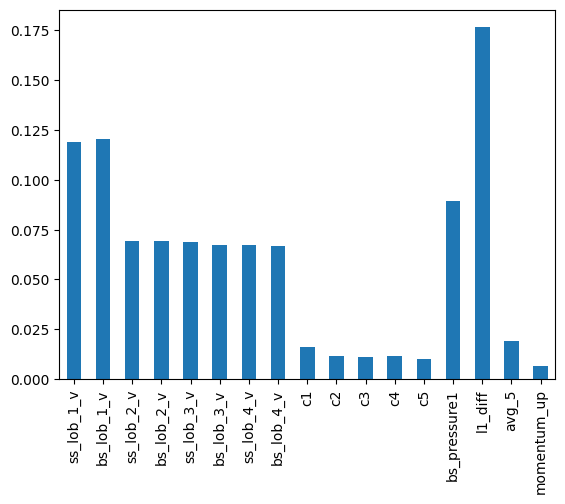

Index(['ss_lob_1_v', 'bs_lob_1_v', 'ss_lob_2_v', 'bs_lob_2_v', 'ss_lob_3_v',
       'bs_lob_3_v', 'ss_lob_4_v', 'bs_lob_4_v', 'c1', 'c2', 'c3', 'c4', 'c5',
       'bs_pressure1', 'l1_diff', 'avg_5', 'momentum_up'],
      dtype='object')

In [103]:
s.plot.bar();plt.show()
s.index
